## Data and Package Importing

### Import packages 

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from QC import *
sc.settings.set_figure_params(dpi=100)

### Load data and preprocess

In [2]:
adata = sc.read_h5ad("s1_raw.h5ad")

In [ ]:
reorder_AnnData(adata) #quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality

In [4]:
#create new "observation" as percent mito and n counts
mito_genes = adata.var_names.str.startswith('mt-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['n_counts']

### Find inflection point

Inflection point at index
bcDZZU     4627
bcBTQF     3644
bcAGFS     6859
bcHRFF    13715
Name: n_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


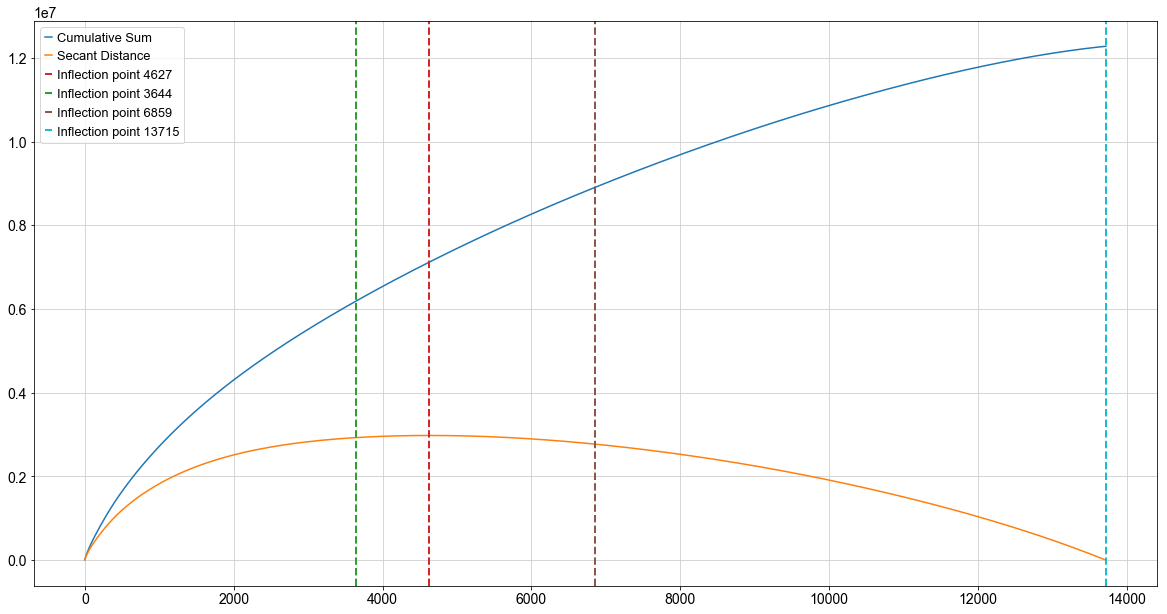

In [5]:
find_inflection(adata)

In [6]:
#filter cells out based on minimum quality
sc.pp.filter_cells(adata,min_counts=adata.obs.iloc[4627].n_counts)

In [7]:
adata.raw = adata #checkpoint before normalizing and scaling data

### Normalize and perform linear dimensionality reduction with PCA

In [8]:
sc.pp.normalize_total(adata) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata) #log1p normalization

In [9]:
#same as above but wrapped up in one function and utilizes the arcsinh transform instead of log1p, commented out for convenience
#arcsinh_transform(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 4628 × 80009 
    obs: 'n_counts', 'percent_mito'

In [11]:
sc.pp.scale(adata) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata) #performing PCA

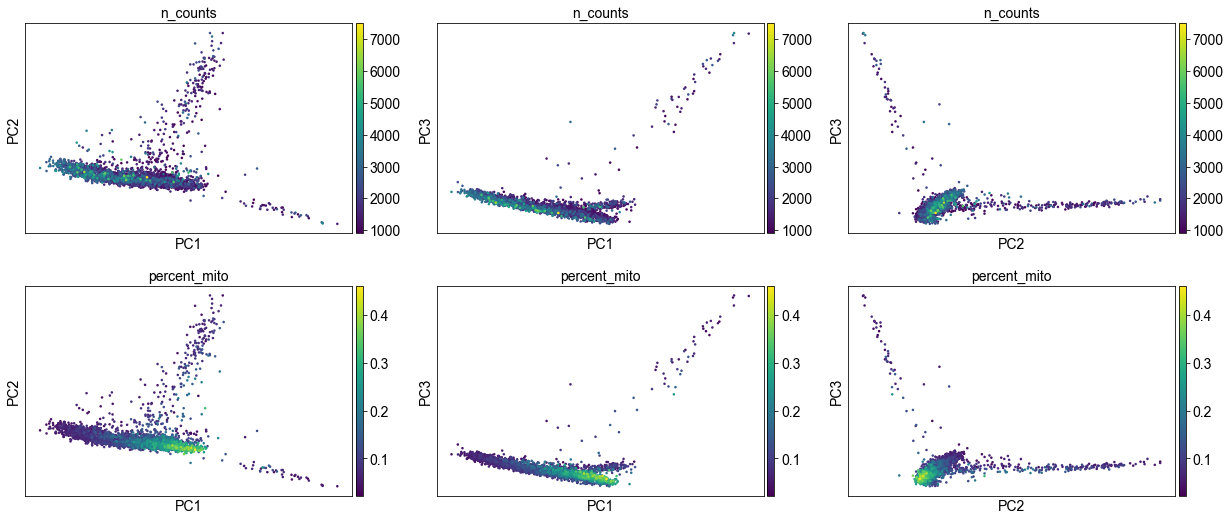

In [12]:
sc.pl.pca(adata, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

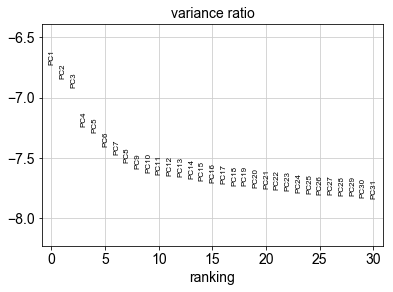

In [13]:
sc.pl.pca_variance_ratio(adata, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [14]:
sc.pp.neighbors(adata,n_neighbors=30, n_pcs=20) #UMAP requires this neighborhood calculation first, will give deprecation warnings

/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages

In [15]:
sc.tl.umap(adata) #perform UMAP

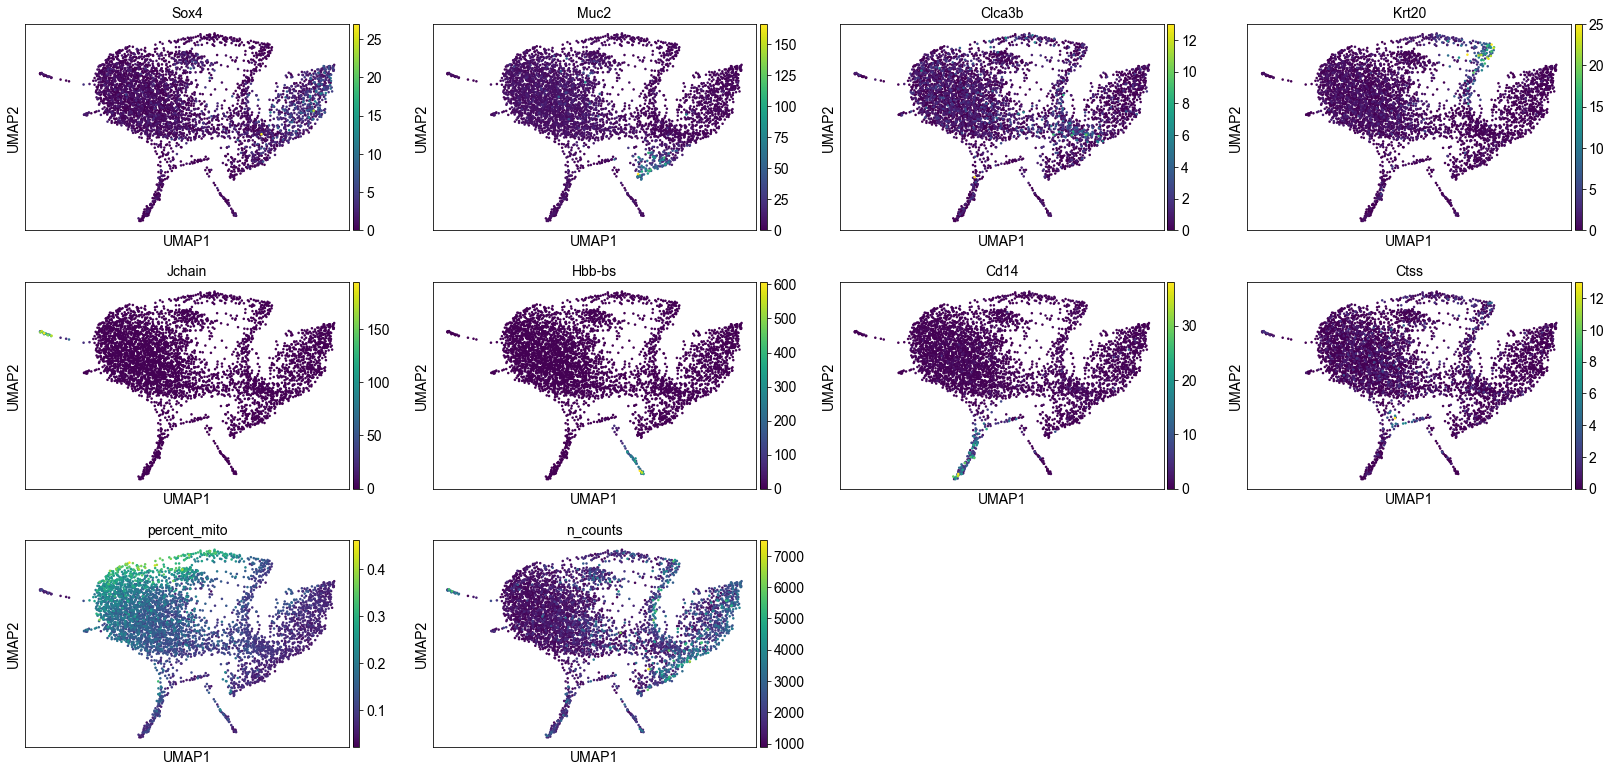

In [16]:
sc.pl.umap(adata,color=['Sox4','Muc2','Clca3b','Krt20','Jchain','Hbb-bs','Cd14','Ctss','percent_mito','n_counts']) #plot marker genes to determine which clusters to keep or gate out

### Clustering and gating

In [17]:
sc.tl.louvain(adata,resolution=1.6) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

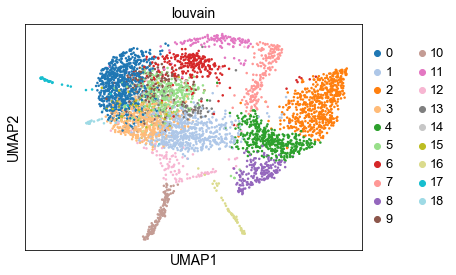

In [18]:
sc.pl.umap(adata, color=['louvain'],wspace=0.5,palette='tab20')

In [19]:
to_keep = np.where(adata.obs['louvain'].isin(['2','4','7','8']))[0] #fill in the indices of the clusters you want to keep here

In [20]:
adata_filtered = sc.AnnData(adata.raw.X[to_keep,:]) #subsetting the original data to make a filtered dataset
adata_filtered.obs = adata.obs.iloc[to_keep,:] #subsetting the original data to make a filtered dataset
adata_filtered.var = adata.var #transferring variable/feature names 

In [21]:
adata_filtered #quick check of reduced/filtered dataset properties

AnnData object with n_obs × n_vars = 1335 × 80009 
    obs: 'n_counts', 'percent_mito', 'louvain'

In [22]:
adata_filtered.write_h5ad("s1_filtered.h5ad",compression='gzip') #optional saving results to file as compressed .h5ad 

### Verify dataset filtering


Inflection point at index
bcFQVV     542
bcAMEV     445
bcFQAI     353
bcHRFF    1334
Name: n_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


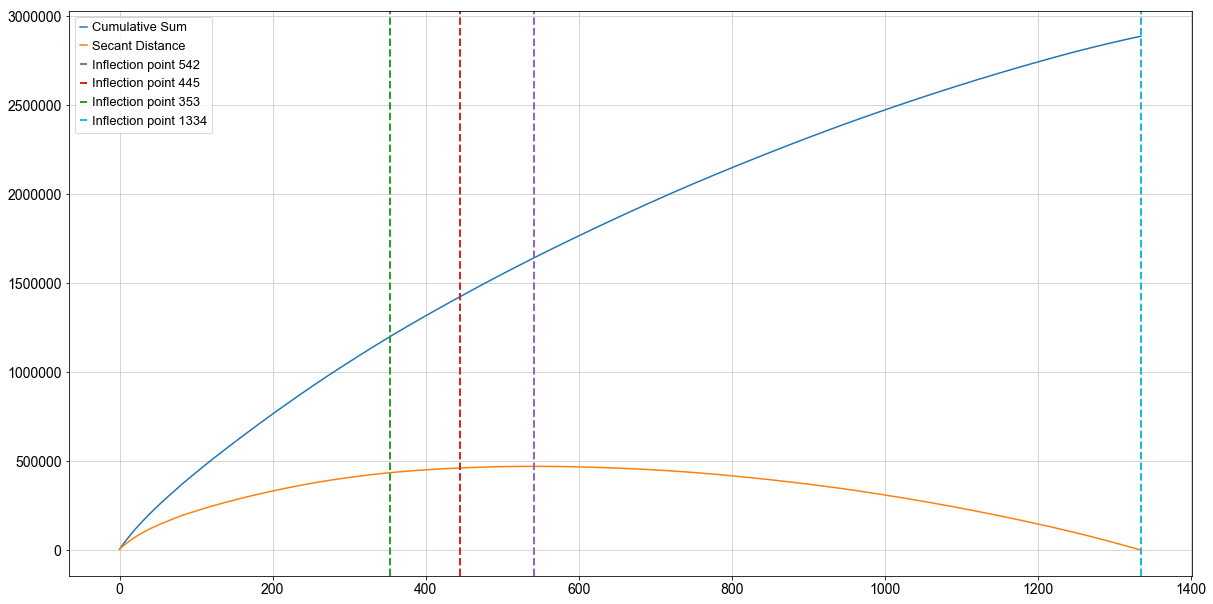

In [23]:
find_inflection(adata_filtered) 
#this is QC analysis on the filtered dataset, this inflection curve should be much more linear with a less obvious "elbow"
#likely do not have to filter out any cells here by library size, so we keep them all

### Normalize and perform linear dimensionality reduction with PCA

In [24]:
adata_filtered.raw = adata_filtered #checkpoint of filtered counts before normalizing and transforming

In [25]:
sc.pp.normalize_total(adata_filtered) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata_filtered) #log1p normalization
sc.pp.scale(adata_filtered) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata_filtered) #performing PCA

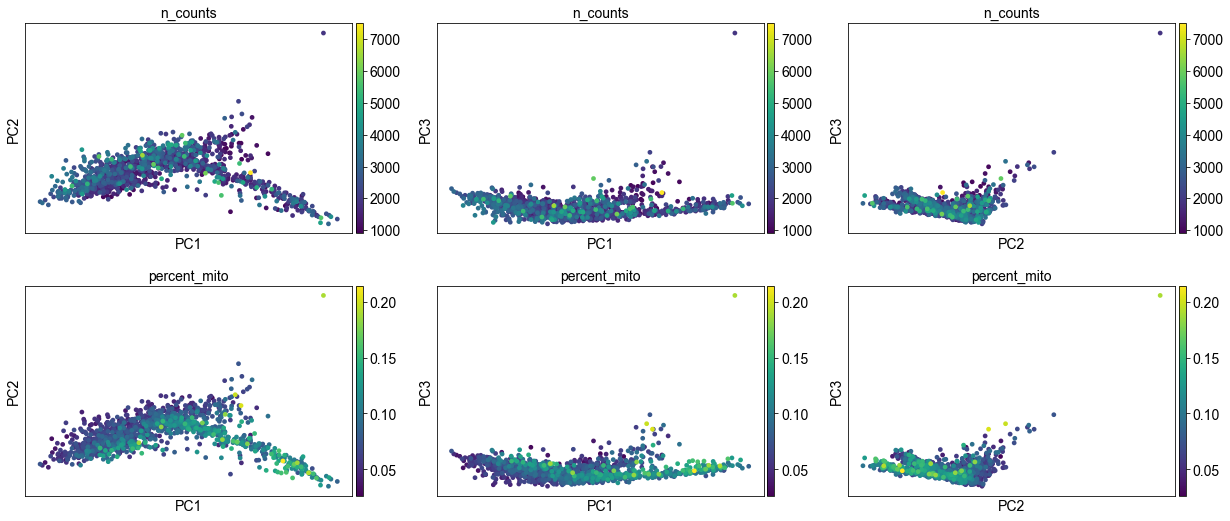

In [26]:
sc.pl.pca(adata_filtered, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

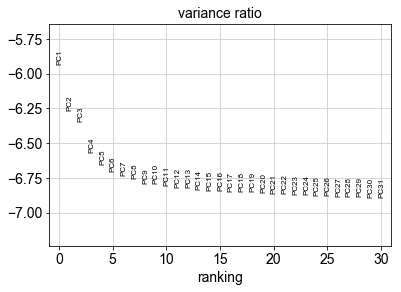

In [27]:
sc.pl.pca_variance_ratio(adata_filtered, log=True)

In [28]:
sc.pp.neighbors(adata_filtered,n_neighbors=30, n_pcs=20) #will give deprecation warnings but still works

In [29]:
sc.tl.umap(adata_filtered)

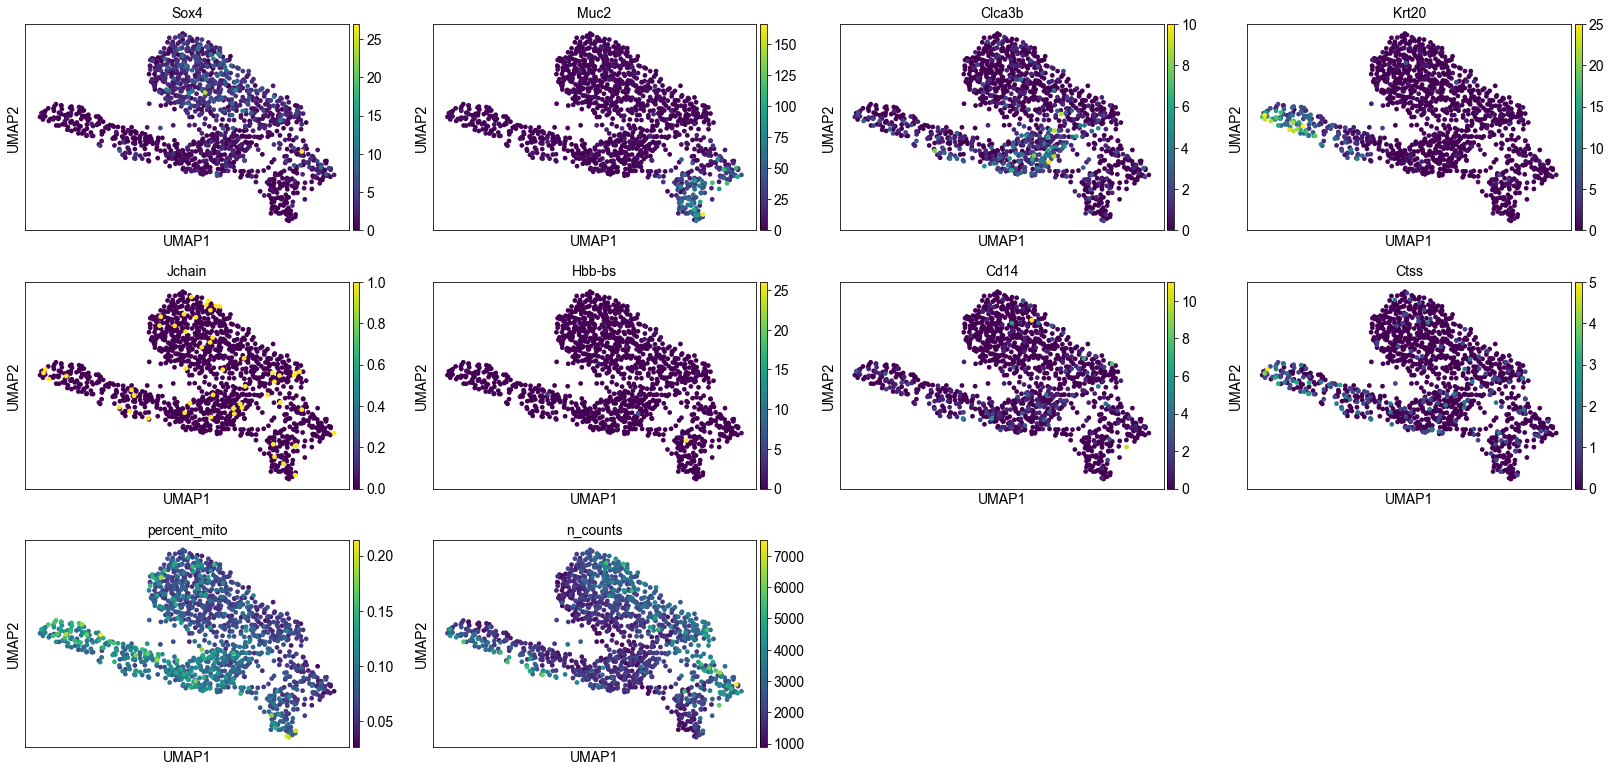

In [30]:
sc.pl.umap(adata_filtered,color=['Sox4','Muc2','Clca3b','Krt20','Jchain','Hbb-bs','Cd14','Ctss','percent_mito','n_counts'])

In [31]:
adata = sc.read_h5ad("s1_raw.h5ad") #import dataset

In [5]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
descending_order = np.argsort(adata.obs['n_counts'])[::-1]
adata.X = adata.X[descending_order,:].copy()
adata.obs = adata.obs.iloc[descending_order].copy()

In [6]:
#create new "observation" as percent mito and n counts
mito_genes = adata.var_names.str.startswith('mt-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['n_counts']

### Find inflection point

Inflection point at index
bcDZZU     4627
bcBTQF     3644
bcAGFS     6859
bcHRFF    13715
Name: n_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


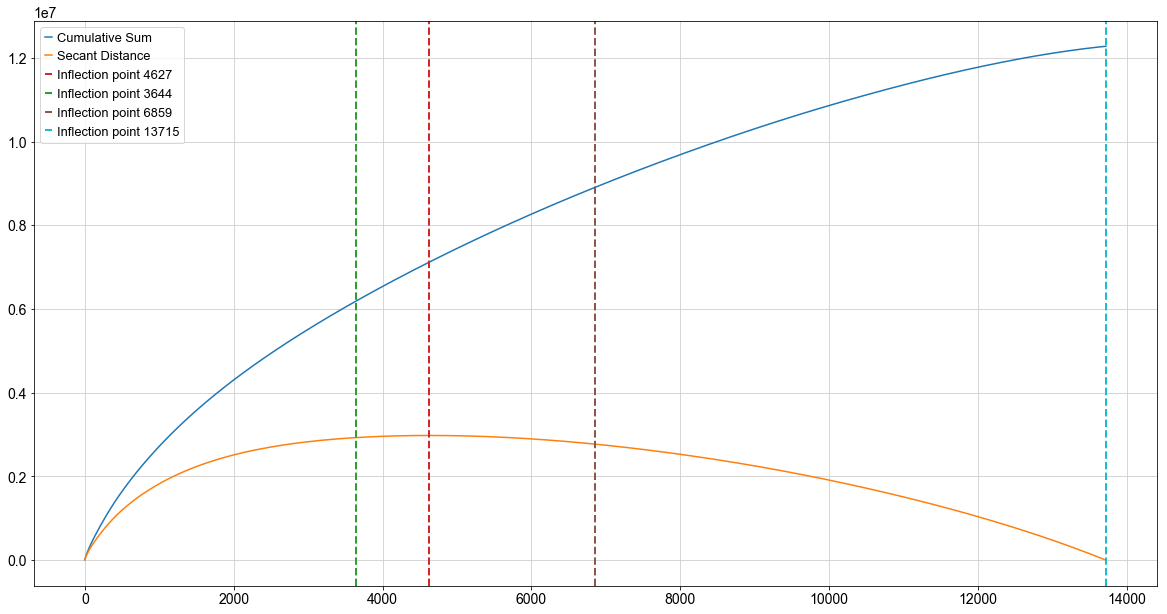

In [7]:
find_inflection(adata)

In [8]:
#filter cells out based on minimum quality
sc.pp.filter_cells(adata,min_counts=adata.obs.iloc[4627].n_counts)

In [9]:
adata.raw = adata #checkpoint before normalizing and scaling data

### Normalize and perform linear dimensionality reduction with PCA

In [10]:
sc.pp.normalize_total(adata) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata) #log1p normalization
sc.pp.scale(adata) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata) #performing PCA

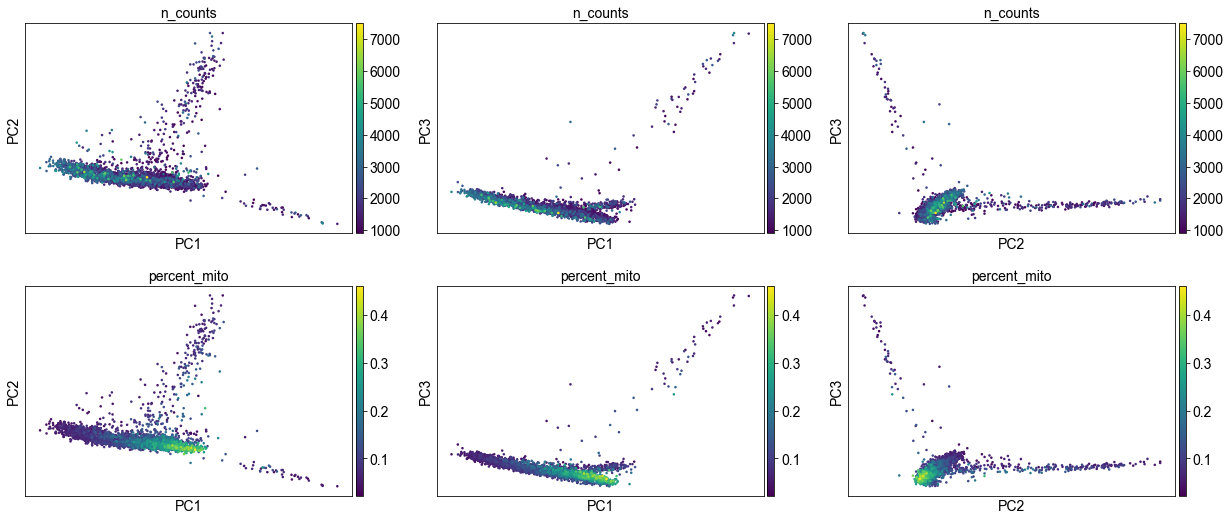

In [11]:
sc.pl.pca(adata, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

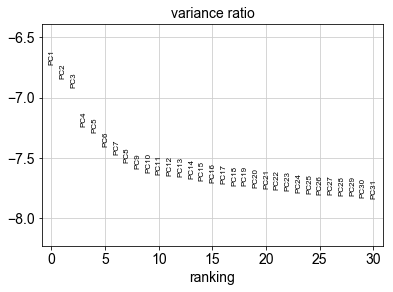

In [12]:
sc.pl.pca_variance_ratio(adata, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [13]:
sc.pp.neighbors(adata,n_neighbors=30, n_pcs=20) #UMAP requires this neighborhood calculation first, will give deprecation warnings

/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/bob/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/compi

In [14]:
sc.tl.umap(adata) #perform UMAP

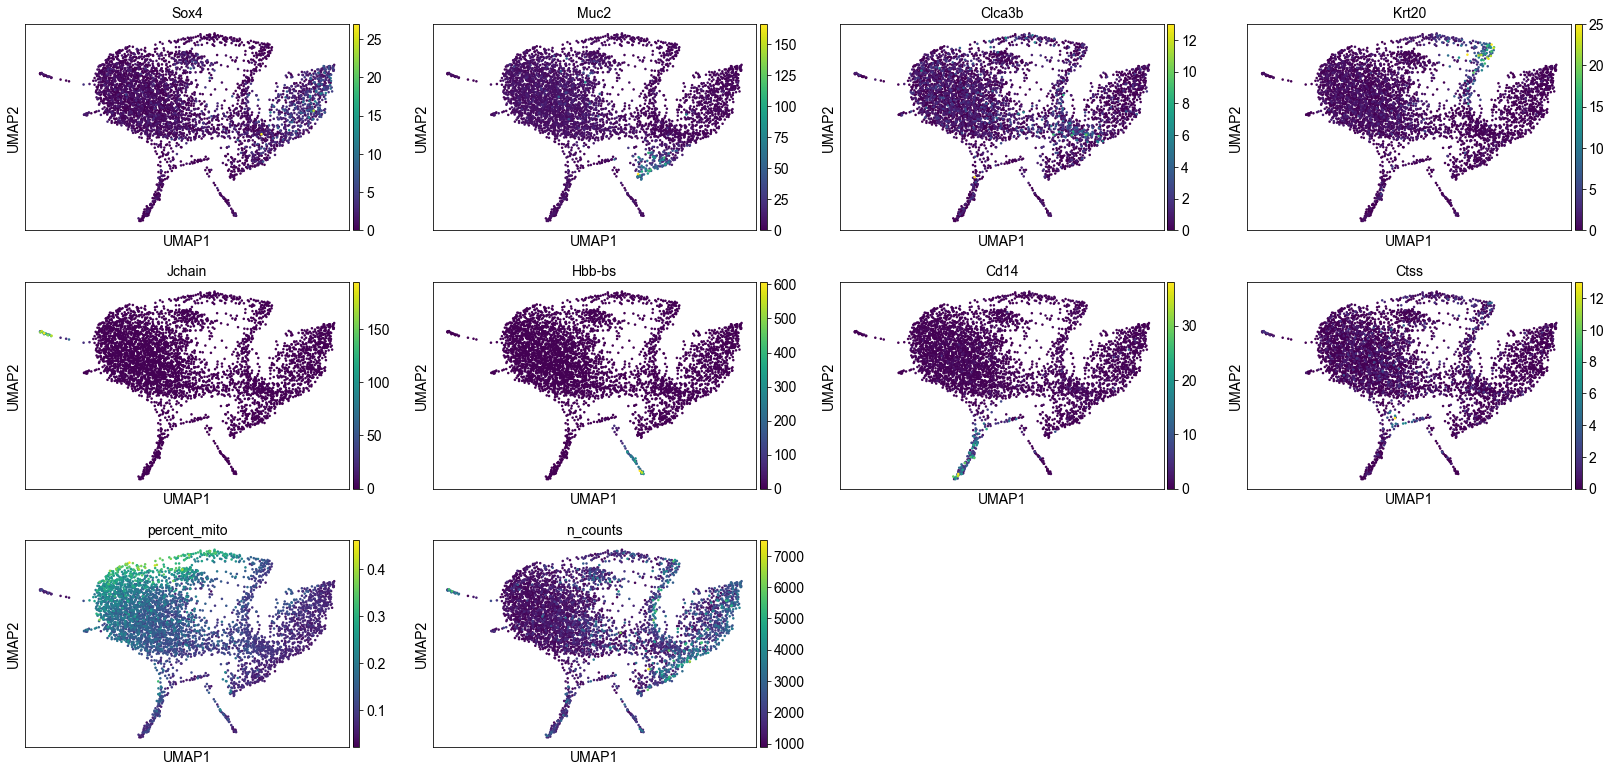

In [15]:
sc.pl.umap(adata,color=['Sox4','Muc2','Clca3b','Krt20','Jchain','Hbb-bs','Cd14','Ctss','percent_mito','n_counts']) #plot marker genes to determine which clusters to keep or gate out

### Clustering and gating

In [16]:
sc.tl.louvain(adata,resolution=1.6) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

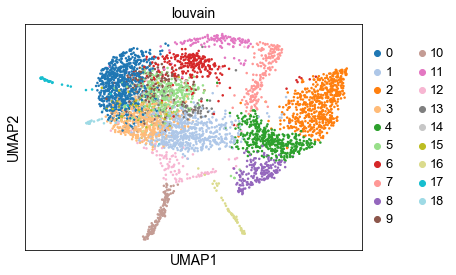

In [17]:
sc.pl.umap(adata, color=['louvain'],wspace=0.5,palette='tab20')

In [18]:
to_keep = np.where(adata.obs['louvain'].isin(['2','4','7','8']))[0] #fill in the indices of the clusters you want to keep here

In [19]:
adata_filtered = sc.AnnData(adata.raw.X[to_keep,:]) #subsetting the original data to make a filtered dataset
adata_filtered.obs = adata.obs.iloc[to_keep,:] #subsetting the original data to make a filtered dataset
adata_filtered.var = adata.var #transferring variable/feature names 

In [20]:
adata_filtered #quick check of reduced/filtered dataset properties

AnnData object with n_obs × n_vars = 1335 × 80009 
    obs: 'n_counts', 'percent_mito', 'louvain'

In [21]:
adata_filtered.write_h5ad("s1_filtered.h5ad",compression='gzip') #optional saving results to file as compressed .h5ad 

### Verify dataset filtering


Inflection point at index
bcFQVV     542
bcAMEV     445
bcFQAI     353
bcHRFF    1334
Name: n_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


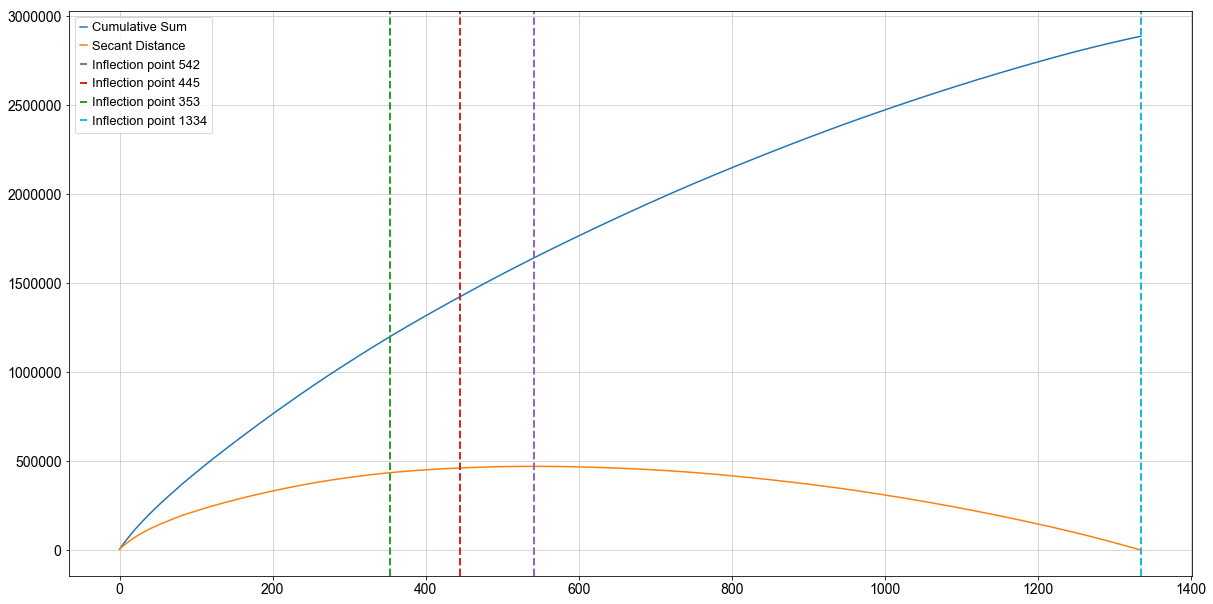

In [22]:
find_inflection(adata_filtered) 
#this is QC analysis on the filtered dataset, this inflection curve should be much more linear with a less obvious "elbow"
#likely do not have to filter out any cells here by library size, so we keep them all

### Normalize and perform linear dimensionality reduction with PCA

In [25]:
adata_filtered.raw = adata_filtered #checkpoint of filtered counts before normalizing and transforming

In [26]:
sc.pp.normalize_total(adata_filtered) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata_filtered) #log1p normalization
sc.pp.scale(adata_filtered) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata_filtered) #performing PCA

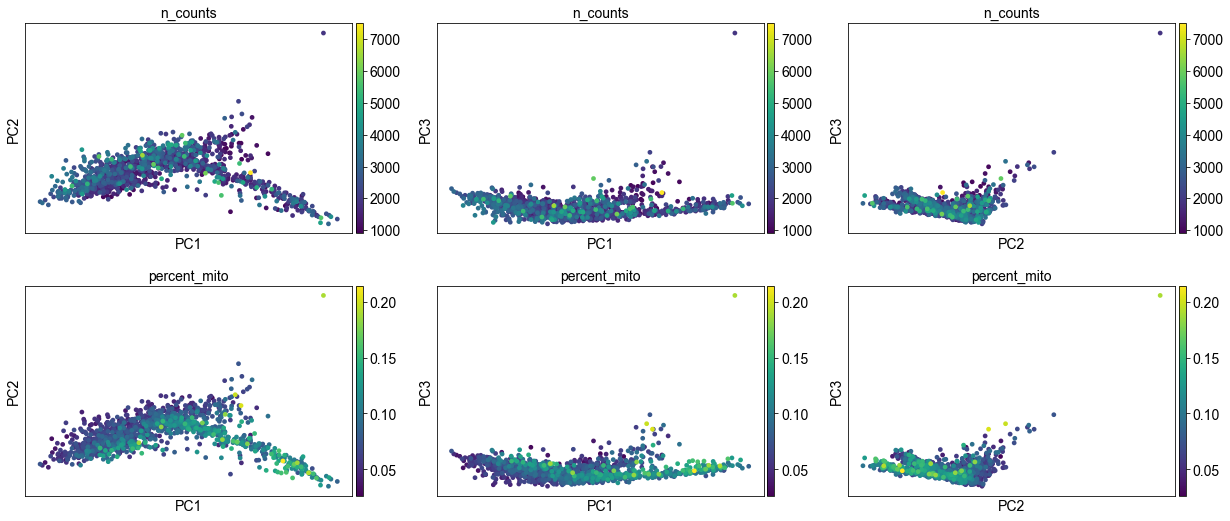

In [27]:
sc.pl.pca(adata_filtered, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

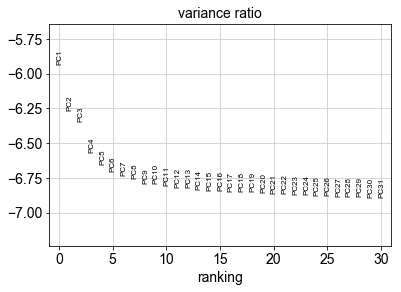

In [28]:
sc.pl.pca_variance_ratio(adata_filtered, log=True)

In [29]:
sc.pp.neighbors(adata_filtered,n_neighbors=30, n_pcs=20) #will give deprecation warnings but still works

In [30]:
sc.tl.umap(adata_filtered)

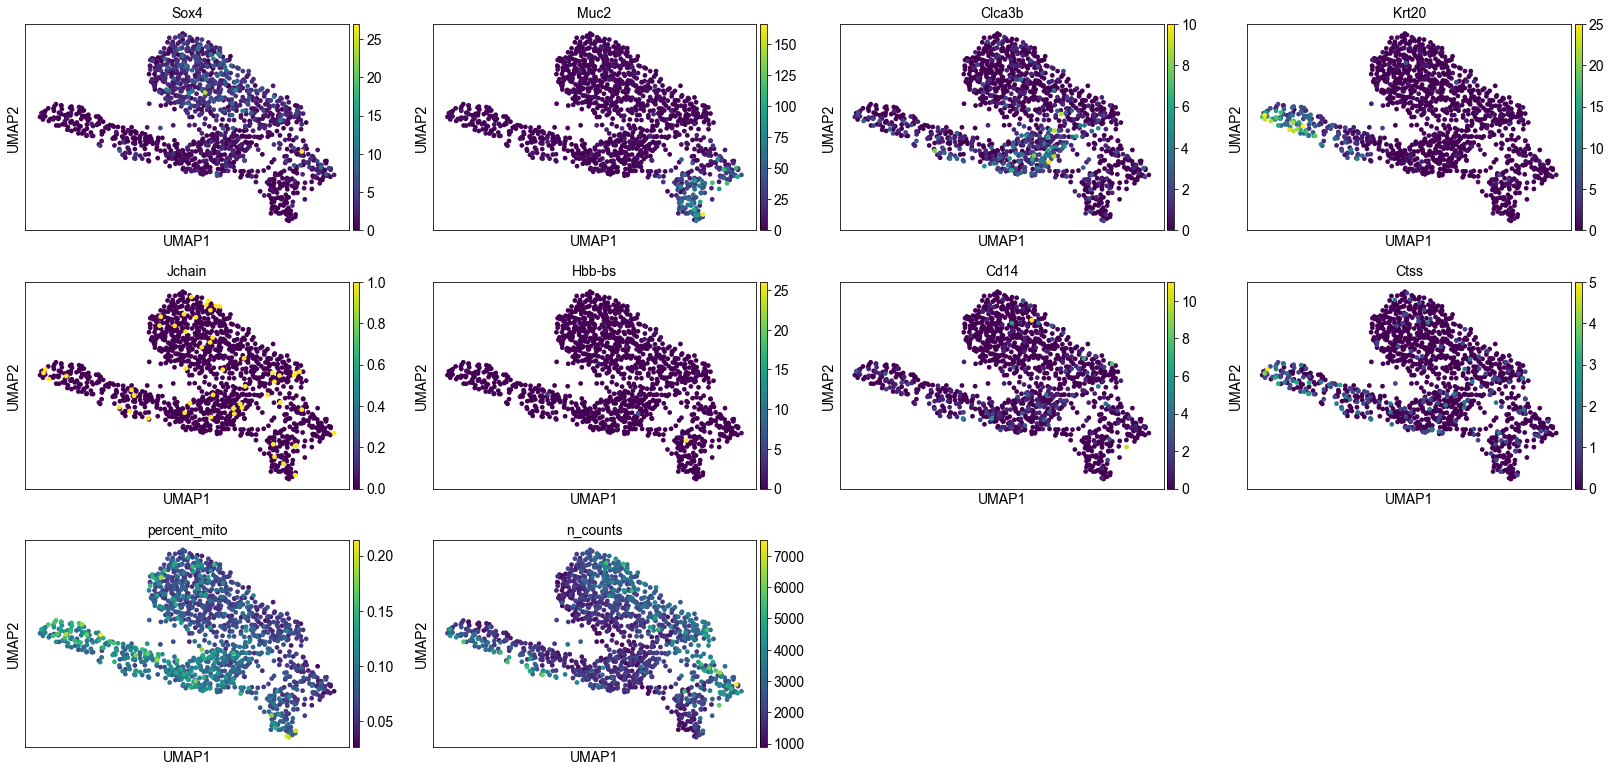

In [31]:
sc.pl.umap(adata_filtered,color=['Sox4','Muc2','Clca3b','Krt20','Jchain','Hbb-bs','Cd14','Ctss','percent_mito','n_counts'])